# **Trabalho 2**
## Grupo 22
João Marques - a84684

Saimon Alves - a76575

In [2]:
import networkx as nx
import random 
import matplotlib.pyplot as plt
!pip install ortools
from ortools.linear_solver import pywraplp
import numpy

# Exercício 1

1. Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido . 
    >  O grafo tem de ser ligado o que significa que entre cada par de nodos $\langle n_1,n_2 \rangle$ tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$.
    1. Gerar aleatoriamente um tal grafo com  $N=32$ nodos.  Cada nodo tem um número aleatório de descendentes no intervalo $\,1..3\,$ cujos destinos são distintos entre si do nodo origem. 
    2. Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.

* Criamos uma função que aproveitando-se da função <u>is_strongly_connected</u> da $NetworkX$ cria um grafo fortemente conexo aleatório, com N nodos, e em que cada nodo tem um número aleatório de descendentes no intervalo de $[1,3]$

In [16]:
def gerar(N):
    g = nx.DiGraph()
    
    #gerar continuamente grafos até conseguirmos gerar um fortemente conexo
    while(nx.is_empty(g) or nx.is_strongly_connected(g) != True ):
        #Adicionar ao grafo N nodos
        for n in range(N):
            g.add_node(n)
    
        #A cada nodo adicionar adicionar 1 a 3 descendentes 
        for n in g.nodes():
            k1 = random.randint(1,3)
            for i in range(k1):
                k2 = random.randint(0,N-1)
                while g.has_edge(n,k2) or g.has_edge(k2,n) or n == k2:
                    k2 = random.randint(0,N-1)
                g.add_edge(n,k2)
            
    
    
    return g

In [22]:
G = gerar(11)

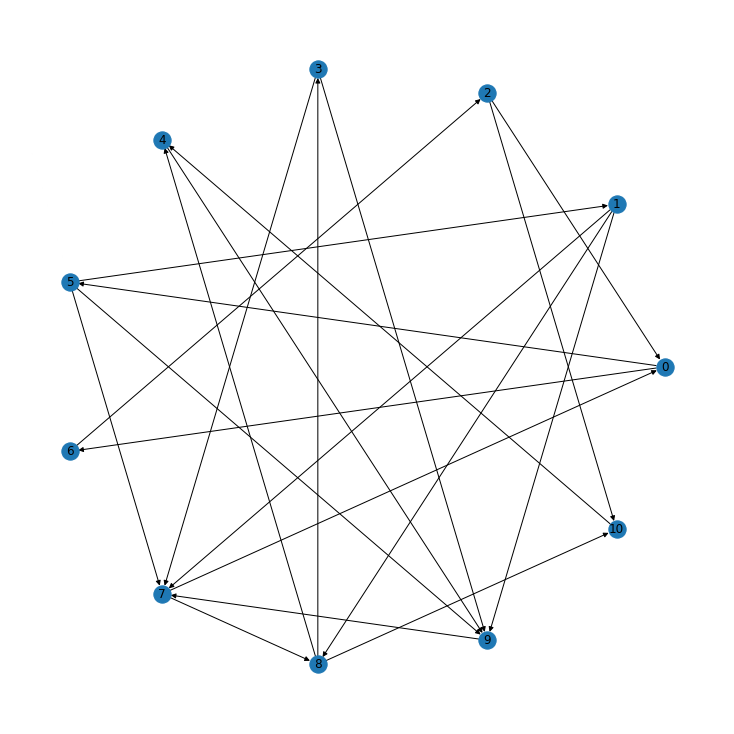

In [23]:
plt.figure(figsize=(10,10))
pos = nx.circular_layout(G)
nx.draw(G,pos,with_labels = True)


* Na função $manutencao$, vamos reduzir ao máximo o número de arestas do grafo G, mantendo o grafo ligado, aproveitando-nos do solver $SCIP$. 
    * Começamos por criar a variável $A_e$ em que se uma aresta e pertence ao grafo $G$ então $A_e = 1$
    * Depois criamos a variável $Caminhos_(o,d)c$, onde $c \in C$, que graças ao uso da <u>all_simple_paths</u> conterá todos os caminhos $c$ entre os vertices $(n1,n2)$
* <u>Restrições</u>:
    1. $ \forall {(o,d) \in G}, \forall {c \in C} , \forall {e \in c} , A_e \ge Caminhos_(o,d)c$
    2. $\forall{(o,d)\in G},\sum_{\forall{c \in C}} Caminhos(o,d)c \ge 1$

    

In [24]:
#Determinar o conjunto de arestas de um determinado caminho
def conj(c):
    return [(c[i],c[i+1]) for i in range(len(c)-1)]

In [25]:
def manutencao(g):
    manu = pywraplp.Solver_CreateSolver('SCIP')
    A = {}

    #criar variáveis para todas as arestas
    for e in g.edges():
        A[e]=manu.BoolVar(str(e))
    
    #garantir que existe um caminho entre cada par de vértices
    for n1 in g.nodes():
        for n2 in g.nodes():
            if (n1!=n2):
                caminhos = {}
                counter = 0
                for c in nx.all_simple_paths(g,n1,n2):
                    #adicionar variáveis para as arestas do caminho
                    caminhos[counter] = manu.BoolVar('(' + str(n1) + str(n2) + ") -" + str(counter))
                    for arestas in conj(c):
                        manu.Add(A[arestas]>=caminhos[counter])
                    manu.Add(sum(caminhos.values())>= 1)
                    counter+=1
    
    #minimizar o número de arestas do grafo
    manu.Minimize(sum(A.values()))
    status = manu.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        rem = []
        for e in g.edges():
            if round(A[e].solution_value()) == 0:
                rem.append(e)
        glinha = g.copy()
        for n1,n2 in g.edges:
            if (n1,n2) in rem:
                glinha.remove_edge(n1,n2) 
        print("O número de vias removidas que podem ser removidas: ", len(rem))
        return glinha

    else:
        print("Impossivel remover arestas mantendo o grafo ligado")
        return g

                
            

O número de vias removidas que podem ser removidas:  5


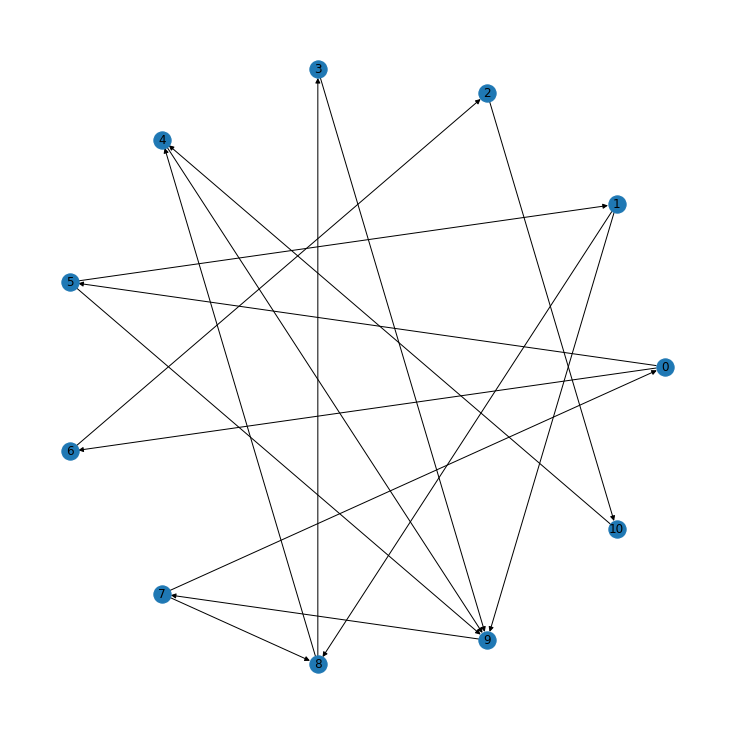

In [26]:
glinha = manutencao(G)
plt.figure(figsize=(10,10))
pos = nx.circular_layout(glinha)
nx.draw(glinha,pos, with_labels = True)

# Exercício 2

 2. Considere-se um circuito booleano $\,\mathcal{C}\,$ com $\,n\,$ “wires” de “input” e um único “wire” de output.
    - O circuito é descrito num bi-grafo com uma classe de nodos representando “gates” e a segunda classe representando “wires” . 
    - Cada nodo contém um campo val cujo conteúdo descreve a semântica desse nodo; para os “wires” o campo val  contém uma variável SCIP; para as “gates” o campo val  contém uma marca bo conjunto and, or,  xor e not,   que indica o tipo de “gate”. 
    - Com exceção de not , que é um operador unário, todas as restantes “gates” têm um número arbitrário de “inputs” e um único “output”.
    - No grafo os arcos com origem numa determinada “gate”  têm destino nos “wires” que são “input” dessa “gate”. Cada “wire” que não é “input” é origem de um único arco que tem como destino a “gate” do qual esse “wire” é “output”.
    - A semântica das várias “gates” é expressa em relações na Aritmética Linear Inteira, tal como está descrita em +Capítulo 2: Programação com Restrições (#LIA)
    
    a. Escreva um programa que, a partir do número $\,n\,$ de “inputs”  e de um parâmetro positivo $\,\gamma\ll 1\,$ como argumentos,  gere aleatoriamente circuitos com “gates” or, and e not  em que o número de and's é  $\,\gamma\ast\,$ (número total de nodos).
    
    b. Escreva um programa Python que leia um circuito arbitrário descrito pelo bi-grafo anterior e formule as restrições (em Programação Inteira) que descrevem as várias “gates” do circuito.
    
    c. Usando os dois programas anteriores e o sistema SCIP: </p>
    - i. Escreva um programa que determine um vetor de “inputs”   $\,x\in\{0,1\}^n\,$ aceite pelo circuito (i.e. o respetivo output é $1$). </p>
    - ii. Determine o vetor $x'\neq x$ , também aceite pelo circuito, que está mais próximo de $x$.

# *Compreensão do Problema*

Para resolver o problema 2, queremos criar um circuito booleano que tenha um certo número obrigatório de "gates" do tipo  𝑎𝑛𝑑  para depois o resolver. 
No circuito existem  𝑁  nodos, os quais têm um valor atribuído, este valor pode ser:  𝑖𝑛𝑝𝑢𝑡  (para os nós que vão ser o vetor de input no circuito),  𝑜𝑢𝑡𝑝𝑢𝑡  (nodos que saiem de um gate),  𝑎𝑛𝑑  (∧),  𝑜𝑟  (∨),  𝑛𝑜𝑡  (¬) e  𝑥𝑜𝑟  (⊕). Os atributos  𝑖𝑛𝑝𝑢𝑡  e  𝑜𝑢𝑡𝑝𝑢𝑡  fazem parte da categoria  𝑤𝑖𝑟𝑒  e os restantes à categoria  𝑔𝑎𝑡𝑒 .


In [10]:
def random_circuit(inp,p):
    g = nx.DiGraph()
    gates = []
    wires = []
    nodos = 0
    n_or = random.randint(1,inp)
    n_not = random.randint(1,inp)
    n_and = int(p * (n_or+n_not))

    #adicionar inputs
    for i in range(inp):
        g.add_node(i, type ='INPUT')
        nodos += 1

    #adicionar gates
    for i in range(n_or):
        nodos+=1
        g.add_node(nodos, type = 'OR')
    for i in range(n_not):
        nodos+=1
        g.add_node(nodos, type='NOT')
    for i in range(n_and):
        nodos+=1
        g.add_node(nodos, type='AND')

    #adicionar wires
    for i in range(nodos-inp):
        g.add_node(nodos+i, type='WIRE')

    for n in g.nodes():
        if g.nodes[n]['type'] != 'INPUT' and g.nodes[n]['type'] != 'WIRE' :
            gates.append(n)
    for n in g.nodes():
        if g.nodes[n]['type'] == "WIRE":
            wires.append(n)

    #emparelhar cada gate com um wire aleatório
    for n in g.nodes():
        if g.nodes[n]['type'] != 'WIRE':
            node = random.choice(wires)
            g.add_edge(n,node)
            wires.remove(node)
    
    #escolher um dos gates emparelhados para servir como output final
    output = random.choice(gates)
  
